# **Import the Libraries**

In [2]:
# Installing twython
!pip install twython

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import re
import nltk
nltk.download('vader_lexicon')
from tqdm import tqdm
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.utils as ku
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
# Loading the data
df=pd.read_csv('train.csv')

# Check the shape of the data
print(df.shape)

(31962, 3)


In [6]:
print(df.head())

   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation


In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB
None


In [111]:
df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

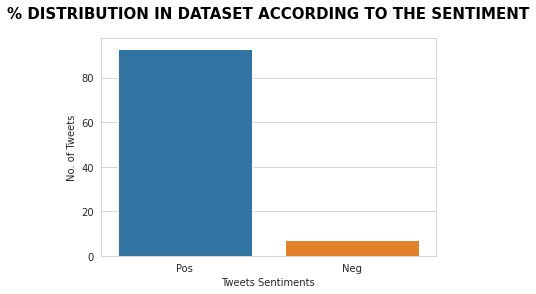

No handles with labels found to put in legend.


In [12]:
sn.set_style('whitegrid');
ax=sn.barplot(x=['Pos','Neg'], y=df.label.value_counts()*100/df.label.value_counts().sum());
ax.set_title('% DISTRIBUTION IN DATASET ACCORDING TO THE SENTIMENT',loc='center', pad=20, fontdict={'fontsize': 15,
        'fontweight': 'bold',
        'color': 'black',
        'verticalalignment': 'baseline',
        });
ax.set(xlabel='Tweets Sentiments', ylabel='No. of Tweets');
plt.show()
ax.legend()
ax.figure.savefig('Total-positive-negative-counts.png',pad_inches=5)

In [13]:
# Observe tweet
y_value_counts=df['label'].value_counts()
print("Negative tweets  = ",y_value_counts[1], "with percentage ", (y_value_counts[1]*100)/(y_value_counts[0]+y_value_counts[1]),'%')
print("Positive tweets  = ",y_value_counts[0], "with percentage ", (y_value_counts[0]*100)/(y_value_counts[0]+y_value_counts[1]),'%')

Negative tweets  =  2242 with percentage  7.014579813528565 %
Positive tweets  =  29720 with percentage  92.98542018647143 %


# **Data Preprocessing**

Since the data is in text format, we have to preprocess the data and clean the data to vectorize the data.

In [14]:
# Replacing all blanlk spaces, - with underscore
# Converting all letters to lower case
df['tweet']=df['tweet'].str.replace(' ','_')
df['tweet']=df['tweet'].str.replace('-','_')
df['tweet']=df['tweet'].str.lower()

In [15]:
df.tweet[:10]

0    _@user_when_a_father_is_dysfunctional_and_is_s...
1    @user_@user_thanks_for_#lyft_credit_i_can't_us...
2                                __bihday_your_majesty
3    #model___i_love_u_take_with_u_all_the_time_in_...
4              _factsguide:_society_now____#motivation
5    [2/2]_huge_fan_fare_and_big_talking_before_the...
6    _@user_camping_tomorrow_@user_@user_@user_@use...
7    the_next_school_year_is_the_year_for_exams.ð...
8    we_won!!!_love_the_land!!!_#allin_#cavs_#champ...
9    _@user_@user_welcome_here_!__i'm___it's_so_#gr...
Name: tweet, dtype: object

In [16]:
def expand(sent):
    "This function will replace english short notations with full form"
    
    sent=re.sub(r"can't", "can not",sent)
    sent=re.sub(r"won't", "will not",sent)
    
    sent=re.sub(r"n\'t", " not",sent)
    sent=re.sub(r"\'re", " are",sent)
    sent=re.sub(r"\'m"," am",sent)
    sent=re.sub(r"\'s"," is",sent)
    sent=re.sub(r"\'ll"," will",sent)
    sent=re.sub(r"\'ve"," have",sent)
    sent=re.sub(r"\'d"," would",sent)
    sent=re.sub(r"\'t", " not",sent)
    
    return sent

In [17]:
# Removing the words from the stop words list: 'no', 'nor', 'not'

stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [19]:
def preprocess_tweet(text):
    "function for preprocess the text data"
    
    preprocessed_tweet=[]
    
    for sentence in tqdm(text):
        sent=expand(sentence)
        sent=sent.replace("\\r"," ")
        sent=sent.replace("\\n"," ")
        sent=sent.replace('\\"'," ")
        sent=re.sub("[^A-Za-z0-9]+"," ",sent)
      
        sent=" ".join(i for i in sent.split() if i.lower() not in stopwords)
        preprocessed_tweet.append(sent.lower().strip())
        
    return preprocessed_tweet
        

In [20]:
preprocessed_tweets=preprocess_tweet(df['tweet'].values)

100%|██████████| 31962/31962 [00:01<00:00, 18235.62it/s]


In [21]:
df['tweet']=preprocessed_tweets

In [22]:
df["tweet"][10]

'ireland consumer price index mom climbed previous 0 2 0 5 may blog silver gold forex'

In [23]:
word_list=[]
for i in df["tweet"]:
    for j in i.split(' '):
        word_list.append(j)

In [24]:
counter = Counter(word_list)
top10 = counter.most_common(11)

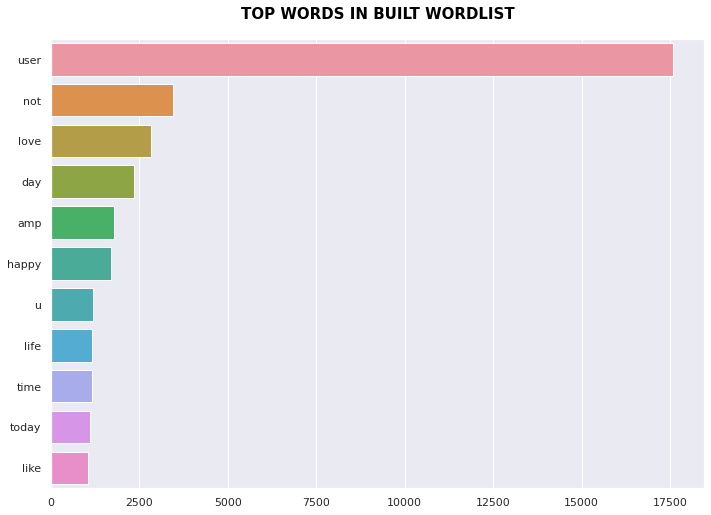

No handles with labels found to put in legend.


In [25]:
xaxes = [i[1] for i in top10]
yaxes = [i[0] for i in top10]

sn.set_style('whitegrid');
sn.set(rc={'figure.figsize':(11.7,8.27)})
ax=sn.barplot(x=xaxes, y=yaxes);
ax.set_title('TOP WORDS IN BUILT WORDLIST',loc='center', pad=20, fontdict={'fontsize': 15,
        'fontweight': 'bold',
        'color': 'black',
        'verticalalignment': 'baseline',
        });
# ax.set(xlabel='Tweets Sentiments', ylabel='No. of Tweets');
plt.show()
ax.legend()
ax.figure.savefig('top10wordscount.png',pad_inches=5)

In [26]:
df[df['label']==0].tweet

0        user father dysfunctional selfish drags kids d...
1        user user thanks lyft credit not use cause not...
2                                           bihday majesty
3                              model love u take u time ur
4                            factsguide society motivation
                               ...                        
31956    fishing tomorrow user carnt wait first time 2 ...
31957                                   ate user isz youuu
31958    see nina turner airwaves trying wrap mantle ge...
31959      listening sad songs monday morning otw work sad
31961                                    thank user follow
Name: tweet, Length: 29720, dtype: object

In [27]:
positive_word=[]
negative_word=[]
for i in df[df['label']==0].tweet:
    for j in i.split(' '):
        positive_word.append(j)
for i in df[df['label']==1].tweet:
    for j in i.split(' '):
        negative_word.append(j)

In [28]:
positive_counter = Counter(positive_word)
negative_counter = Counter(negative_word)

In [29]:
positive_counter.most_common(10),negative_counter.most_common(10)

([('user', 15714),
  ('not', 3108),
  ('love', 2796),
  ('day', 2336),
  ('happy', 1694),
  ('amp', 1476),
  ('life', 1163),
  ('u', 1150),
  ('time', 1127),
  ('today', 1078)],
 [('user', 1863),
  ('not', 353),
  ('amp', 300),
  ('trump', 213),
  ('libtard', 149),
  ('white', 140),
  ('like', 139),
  ('black', 134),
  ('racist', 108),
  ('politics', 97)])

In [30]:
negative_counter.get('friday')

In [32]:
w = ['good','bad','information']
y1 = []
y2=[]
for i in w:
    y1.append(positive_counter.get(i))
    y2.append(negative_counter.get(i))

y2

[33, 8, 2]

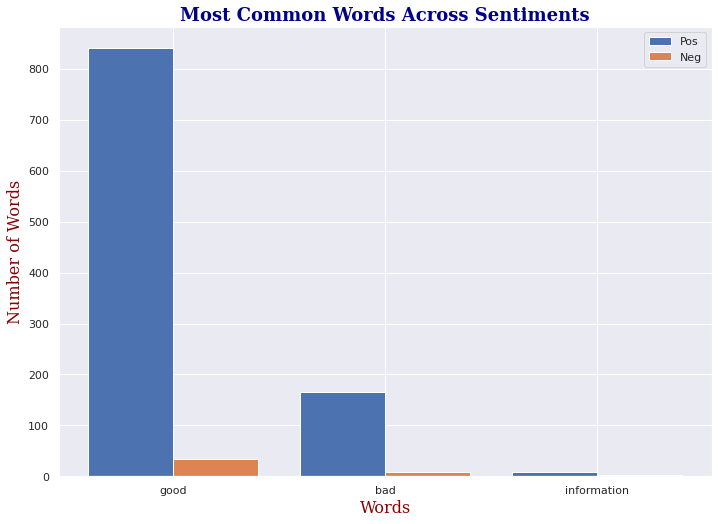

In [33]:
X_axis = np.arange(len(w))
  
plt.bar(X_axis-0.2 , y1, 0.4, label = 'Pos')
plt.bar(X_axis+0.2 , y2, 0.4, label = 'Neg')
  
plt.xticks(X_axis, w)
plt.xlabel("Words", fontdict={'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        })
plt.ylabel("Number of Words", fontdict={'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        })
plt.title("Most Common Words Across Sentiments", fontdict={'family': 'serif',
        'color':  'darkblue',
        'weight': 'bold',
        'size': 18,
        })
plt.legend()
plt.show()

In [34]:
# Cleaning text data
positive_counter.most_common(10), negative_counter.most_common(10)


([('user', 15714),
  ('not', 3108),
  ('love', 2796),
  ('day', 2336),
  ('happy', 1694),
  ('amp', 1476),
  ('life', 1163),
  ('u', 1150),
  ('time', 1127),
  ('today', 1078)],
 [('user', 1863),
  ('not', 353),
  ('amp', 300),
  ('trump', 213),
  ('libtard', 149),
  ('white', 140),
  ('like', 139),
  ('black', 134),
  ('racist', 108),
  ('politics', 97)])

In [35]:
# Splitting data into train and test
y=df['label']
x=df.drop(['label'],axis=1)

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,stratify=y,random_state=40)

x_test

,id,tweet
25807,25808,proud congressional co chairs womeninpolitics ...
28366,28367,root beer storm rootbeer storm rain thunder li...
30638,30639,bard marocan teapot designed elhabiba maroc de...
19319,19320,hating conservative homophobes using tragedy w...
16207,16208,redneck island woohoo pumped redneck woo hoo h...
...,...,...
844,845,great way spend saturday relaxation positivevi...
11901,11902,preach happiness goodvibes positivevibes yoga ...
15357,15358,w beloved husband ever
31630,31631,oh wow bernie dropping ourrevolution trump wom...


**Vectorization**

In [36]:
# TFIDF for text data
vect=TfidfVectorizer(min_df=10)

vect.fit(x_train['tweet'].values)

train_tweet=vect.transform(x_train['tweet'].values)
test_tweet=vect.transform(x_test['tweet'].values)

print(train_tweet.shape,y_train.shape)
print(test_tweet.shape,y_test.shape)

(25569, 2763) (25569,)
(6393, 2763) (6393,)


In [40]:
#calculating sentiment scores for train data
x_train_sent=np.ndarray.tolist(x_train["tweet"].values)

sia=SentimentIntensityAnalyzer()
ps=[]
for i in range(len(x_train_sent)):
    ps.append((sia.polarity_scores((x_train_sent[i]))))
    
x_train_polarity=np.array(ps)
x_train_polarity=x_train_polarity.reshape(-1,1)
x_train_polarity.shape

(25569, 1)

In [41]:
#storing only scores of sentiment
x_t=[]
for i in range(len(x_train)):
    for j in x_train_polarity[0][0]:
        x_t.append(x_train_polarity[i][0][j])
x_t=np.array(x_t)
x_t=x_t.reshape(-1,4)
x_t.shape

(25569, 4)

In [42]:
#calculating sentiment scores for test data
x_test_sent=np.ndarray.tolist(x_test["tweet"].values)

sia=SentimentIntensityAnalyzer()
ps=[]
for i in range(len(x_test_sent)):
    ps.append((sia.polarity_scores((x_test_sent[i]))))
    
x_test_polarity=np.array(ps)
x_test_polarity=x_test_polarity.reshape(-1,1)
x_test_polarity.shape

(6393, 1)

In [43]:
#storing only scores of sentiment
x_tests=[]
for i in range(len(x_test)):
    for j in x_test_polarity[0][0]:
        x_tests.append(x_test_polarity[i][0][j])
x_tests=np.array(x_tests)
x_tests=x_tests.reshape(-1,4)
x_tests.shape

(6393, 4)

In [44]:
# Convert the vectors into scipy.sparse matrix
from scipy.sparse import hstack

In [45]:
x_tr=hstack((train_tweet,x_t))
x_te=hstack((test_tweet,x_tests))

print(x_tr.shape)
print(x_te.shape)

(25569, 2767)
(6393, 2767)


In [46]:
print(test_tweet)

  (0, 1933)	0.4799627799627368
  (0, 555)	0.656373312175343
  (0, 511)	0.5820737108944289
  (1, 2322)	0.7984558839207088
  (1, 1969)	0.349396822751368
  (1, 418)	0.33484162995223826
  (1, 258)	0.35814961194251915
  (2, 1780)	0.5563435228696378
  (2, 1480)	0.2499926175684175
  (2, 1292)	0.5930233558005863
  (2, 658)	0.5256509062080108
  (3, 2639)	0.2521714854687438
  (3, 2575)	0.3606122930334627
  (3, 2501)	0.4242291759698843
  (3, 2494)	0.3553423653518665
  (3, 1756)	0.263006241008935
  (3, 1702)	0.16239895286026026
  (3, 1651)	0.3533835813763681
  (3, 1284)	0.3732363976083819
  (3, 164)	0.37469809031520196
  (4, 2703)	0.5253527784749055
  (4, 2589)	0.3528305059935181
  (4, 1939)	0.5402403699868036
  (4, 1287)	0.49745050404352376
  (4, 1120)	0.24535368522282383
  :	:
  (6387, 1965)	0.2811262797077729
  (6387, 1307)	0.3302829279042166
  (6387, 877)	0.3685020027471522
  (6387, 534)	0.3517822628767341
  (6387, 437)	0.37474914969807666
  (6387, 403)	0.31864310525678013
  (6387, 142)	0.1755

# **Descision Tree Classifier**

In [47]:
#since the data is imbalanced , we assign some more weight to class 1

wt={0:1,1:5}            
clf=DecisionTreeClassifier(class_weight=wt)

parameters=dict(max_depth=[1,5,10,50],min_samples_split=[5,10,100,500])

search=RandomizedSearchCV(clf,parameters,random_state=10)
result=search.fit(x_tr,y_train)
result.cv_results_

{'mean_fit_time': array([0.10229597, 0.02700148, 0.92945542, 0.09836226, 0.0987834 ,
        0.20541687, 0.19221463, 0.02714038, 0.19173307, 1.02244892]),
 'mean_score_time': array([0.00213294, 0.00141768, 0.00248089, 0.00184264, 0.00165277,
        0.00175586, 0.00207334, 0.0015584 , 0.00179281, 0.00250316]),
 'mean_test_score': array([0.90601893, 0.81841286, 0.91063412, 0.90519764, 0.9059016 ,
        0.92099837, 0.91865181, 0.81841286, 0.91720478, 0.92784227]),
 'param_max_depth': masked_array(data=[5, 1, 50, 5, 5, 10, 10, 1, 10, 50],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[10, 500, 100, 500, 100, 5, 100, 100, 500, 5],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 5, 'min_sam

In [48]:
search.best_params_

{'max_depth': 50, 'min_samples_split': 5}

In [49]:
cls = DecisionTreeClassifier(max_depth=50,min_samples_split=5,random_state=10,class_weight=wt)
cls.fit(x_tr,y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 5}, max_depth=50,
                       min_samples_split=5, random_state=10)

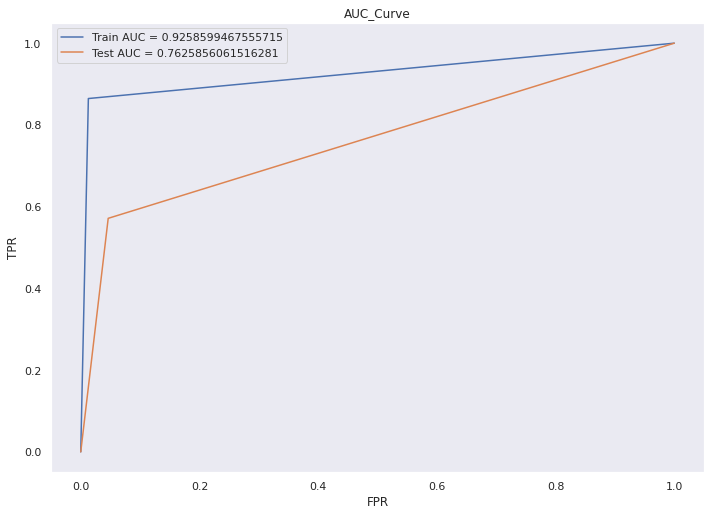

In [50]:
y_pred_train=cls.predict(x_tr)
y_pred_test=cls.predict(x_te)

train_fpr,train_tpr,tr_treshold=roc_curve(y_train,y_pred_train)
test_fpr,test_tpr,te_treshold=roc_curve(y_test,y_pred_test)

train_auc=auc(train_fpr,train_tpr)
test_auc=auc(test_fpr,test_tpr)

plt.plot(train_fpr,train_tpr,label='Train AUC = '+str(train_auc))
plt.plot(test_fpr,test_tpr,label='Test AUC = '+str(test_auc))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("AUC_Curve")
plt.grid()
plt.show()

In [51]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [52]:
#computing confusion matrix for set_1

from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_treshold, train_fpr, train_tpr)
print("Train confusion matrix")
m_tr=(confusion_matrix(y_train, predict_with_best_t(y_pred_train, best_t)))
print(m_tr)
print("Test confusion matrix")
m_te=(confusion_matrix(y_test, predict_with_best_t(y_pred_test, best_t)))
print(m_te)

the maximum value of tpr*(1-fpr) 0.8534575468878033 for threshold 1
Train confusion matrix
[[23470   305]
 [  243  1551]]
Test confusion matrix
[[5670  275]
 [ 192  256]]


In [53]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      5945
           1       0.48      0.57      0.52       448

    accuracy                           0.93      6393
   macro avg       0.72      0.76      0.74      6393
weighted avg       0.93      0.93      0.93      6393



In [54]:
df3 = pd.DataFrame(classification_report(y_pred_test, 
                                        y_test, digits=2,
                                        output_dict=True)).T

df3['support'] = df3.support.apply(int)

df3.style.background_gradient(cmap='viridis',
                             subset=pd.IndexSlice['0':'9', :'f1-score'])

,precision,recall,f1-score,support
0,0.953743,0.967247,0.960447,5862
1,0.571429,0.482109,0.522983,531
accuracy,0.926951,0.926951,0.926951,0
macro avg,0.762586,0.724678,0.741715,6393
weighted avg,0.921988,0.926951,0.924112,6393


In [55]:
dt_df = pd.DataFrame(columns=['tweet', 'sentiment-predicted', 'label'])

In [56]:
# Coloring the elements
def color_negative_red(value):

    if value == 'Positive':
        color = 'green'
    else:
        color='red'

    return 'color: %s' % color

In [57]:
# Classification
dt_df = pd.DataFrame(columns=['tweet', 'sentiment-predicted', 'label'])
dt_df['tweet'] = x_test['tweet']
dt_df['sentiment-predicted'] = y_pred_test
dt_df['label'] =y_test
dt_df.replace(to_replace=[0,1],value=['Positive','Negative'], inplace=True)
(dt_df.sample(10)[['tweet','sentiment-predicted','label']].style
    .applymap(color_negative_red, subset=['sentiment-predicted','label']))

,tweet,sentiment-predicted,label
2179,user talked friend visited germany said country lost refugees throw trash everyplace threatn citi,Positive,Positive
15592,engaging positive affirmation,Positive,Positive
26563,user ordered pearlywhites white glowing,Negative,Positive
22454,quite content selfacceptance selflove inspiration,Positive,Positive
8254,diyscoveries father day leather wallet,Positive,Positive
3747,user us always us,Positive,Positive
4903,countdown sun mallorca relax kids,Positive,Positive
22307,sad happened orlando please pray families victims killed john 15 12 orlando john1512,Positive,Positive
11451,makes hear shootings happen america makeamericasafeagain benice,Positive,Positive
8580,get see boy tonight datenight,Positive,Positive


# **Naive Bayes**

In [58]:
# CountVectorizer
vec=CountVectorizer(min_df=10)
vec.fit(x_train['tweet'].values)

x_tr_count=vec.transform(x_train['tweet'].values)
x_te_count=vec.transform(x_test['tweet'].values)
x_tr_count.shape

(25569, 2763)

In [59]:
x_tr_data=hstack((x_tr_count,x_t))
x_te_data=hstack((x_te_count,x_tests))

x_trn=scipy.sparse.csr_matrix(x_tr_count)
x_tst=scipy.sparse.csr_matrix(x_te_count)

In [60]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import KFold

In [61]:
nb = MultinomialNB()
params = {'alpha': [0.1, 0.5, 1, 2]}
gs = GridSearchCV(nb,param_grid=params, return_train_score=True)
gs.fit(x_trn,y_train)

GridSearchCV(estimator=MultinomialNB(), param_grid={'alpha': [0.1, 0.5, 1, 2]},
             return_train_score=True)

In [62]:
gs.best_estimator_

MultinomialNB(alpha=0.1)

In [63]:
nb = MultinomialNB()
params = {'alpha': [0.1, 2]}
gs = GridSearchCV(nb,param_grid=params, return_train_score=True)
gs.fit(x_trn,y_train)

GridSearchCV(estimator=MultinomialNB(), param_grid={'alpha': [0.1, 2]},
             return_train_score=True)

In [64]:
skf = StratifiedKFold(n_splits=8)
params = {'alpha': [0.1, 2]}
nb = MultinomialNB()
gs = GridSearchCV(nb, cv=skf, param_grid=params, return_train_score=True)
gs.fit(x_trn,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
             estimator=MultinomialNB(), param_grid={'alpha': [0.1, 2]},
             return_train_score=True)

In [65]:
gs.best_score_

0.9443079385868245

In [66]:
train_pred=gs.predict(x_trn)
test_pred=gs.predict(x_tst)

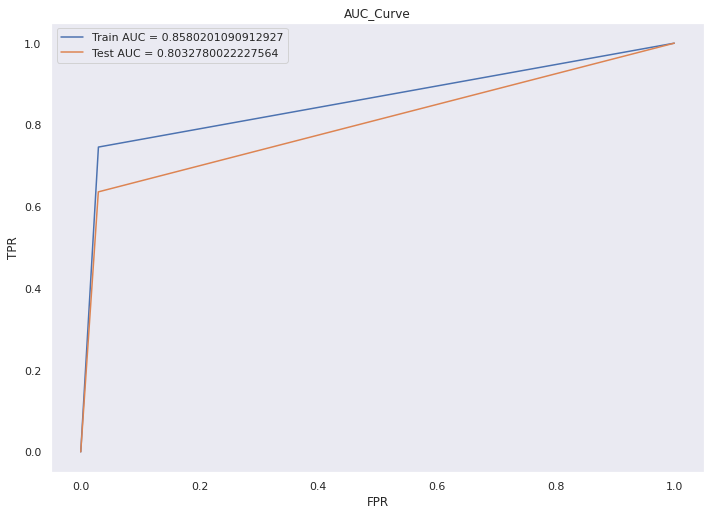

In [67]:
train_fpr,train_tpr,tr_treshold=roc_curve(y_train,train_pred)
test_fpr,test_tpr,te_treshold=roc_curve(y_test,test_pred)

train_auc=auc(train_fpr,train_tpr)
test_auc=auc(test_fpr,test_tpr)

plt.plot(train_fpr,train_tpr,label='Train AUC = '+str(train_auc))
plt.plot(test_fpr,test_tpr,label='Test AUC = '+str(test_auc))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("AUC_Curve")
plt.grid()
plt.show()

In [68]:
df1 = pd.DataFrame(classification_report(gs.predict(x_tst), 
                                        y_test, digits=2,
                                        output_dict=True)).T

df1['support'] = df1.support.apply(int)

df1.style.background_gradient(cmap='viridis',
                             subset=pd.IndexSlice['0':'9', :'f1-score'])

,precision,recall,f1-score,support
0,0.970395,0.972522,0.971457,5932
1,0.636161,0.618221,0.627063,461
accuracy,0.946973,0.946973,0.946973,0
macro avg,0.803278,0.795372,0.799260,6393
weighted avg,0.946294,0.946973,0.946623,6393


In [69]:
mod = MultinomialNB()
mod.fit(x_trn,y_train)

MultinomialNB()

In [70]:
train_pred=mod.predict(x_trn)
test_pred=mod.predict(x_tst)

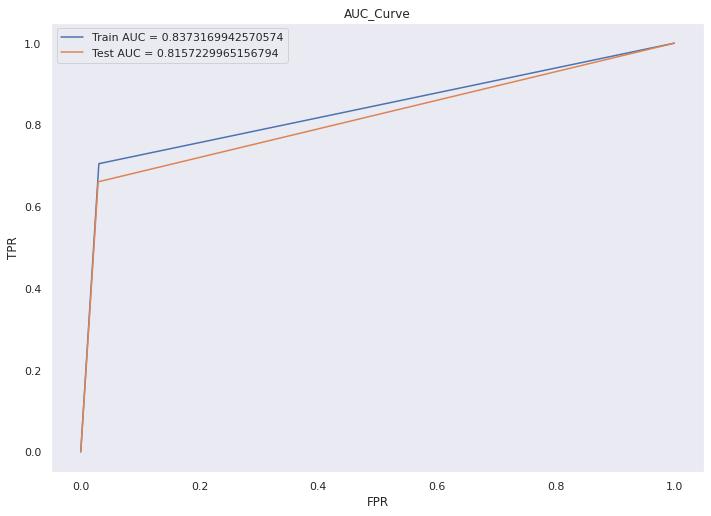

In [71]:
train_fpr,train_tpr,tr_treshold=roc_curve(y_train,train_pred)
test_fpr,test_tpr,te_treshold=roc_curve(y_test,test_pred)

train_auc=auc(train_fpr,train_tpr)
test_auc=auc(test_fpr,test_tpr)

plt.plot(train_fpr,train_tpr,label='Train AUC = '+str(train_auc))
plt.plot(test_fpr,test_tpr,label='Test AUC = '+str(test_auc))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("AUC_Curve")
plt.grid()
plt.show()

In [74]:
# Summary
df1 = pd.DataFrame(classification_report(mod.predict(x_tst), 
                                        y_test, digits=2,
                                        output_dict=True)).T

df1['support'] = df1.support.apply(int)

df1.style.background_gradient(cmap='viridis',
                             subset=pd.IndexSlice['0':'9', :'f1-score'])

,precision,recall,f1-score,support
0,0.970732,0.974337,0.972531,5923
1,0.660714,0.629787,0.644880,470
accuracy,0.949007,0.949007,0.949007,0
macro avg,0.815723,0.802062,0.808706,6393
weighted avg,0.947940,0.949007,0.948443,6393


In [77]:
dt_df = pd.DataFrame(columns=['tweet', 'sentiment-predicted', 'label'])
dt_df['tweet'] = x_test['tweet']
dt_df['sentiment-predicted'] = test_pred
dt_df['label'] =y_test
dt_df.replace(to_replace=[0,1],value=['Positive','Negative'], inplace=True)
(dt_df.sample(10)[['tweet','sentiment-predicted','label']].style
    .applymap(color_negative_red, subset=['sentiment-predicted','label']))

,tweet,sentiment-predicted,label
22927,happy friday zoe friday friday tgifridays beaglemania beagles beagle,Positive,Positive
4447,terrible war world ideology vs humanity equals liveslost problem throughout world,Negative,Positive
4026,oscar tabarez talks luis suarez angry reaction spos luis oscar,Positive,Positive
5844,appreciatesomeone someone would love hear word appreciation,Positive,Positive
13227,lucky positive affirmation,Positive,Positive
17004,today day celebrate active fathers u not child today not 4 u fathersday friends family,Positive,Positive
16091,not watch dumpdrumpf nothappening never gross,Positive,Positive
25049,miss mom dad bad right speechless nobueno,Positive,Positive
38,oh cedarpoint waited 2 hours valravn line stopped working close,Positive,Positive
2435,happiness dogs angel armani chihuahua dogs puppylove loved blessed lucky,Positive,Positive


# **XGBoost**

In [102]:
# Import the libraries
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [103]:
y_train.value_counts()

0    23775
1     1794
Name: label, dtype: int64

In [105]:
xgb = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth={'max_depth': 10}, min_child_weight=1, missing=None,
       n_estimators=100, nthread=-1, objective='binary:logistic',
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

prediction = xgb.predict(x_te) 

f1_score(y_test, prediction)

XGBoostError: ignored

In [85]:
kfmodel = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None,)
kfold = KFold(n_splits=8, random_state=7, shuffle=True)
results = cross_val_score(kfmodel, x_tr, y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
print(results)

Accuracy: nan% (nan%)
[nan nan nan nan nan nan nan nan]


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
8 fits failed out of a total of 8.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py", line 732, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/training.py", line 216, in train
    xgb_model=xgb_model, callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/training.py", line 74,

In [86]:
train_prediction=xgb.predict(x_tr)

NameError: ignored